In [11]:
import numpy as np
import pandas as pd
import statsmodels.api as sm
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

In [195]:
data_test = pd.read_csv('merge_data_2019.csv')
data_train = pd.read_csv('merge_data_2020.csv')

In [196]:
X_train = data_train.drop(['AWS', 'Row Position', 'Column Position', 'name', 'DEM'], axis=1)
y_train = data_train['AWS']
X_test = data_test.drop(['AWS', 'Row Position', 'Column Position', 'name', 'DEM'], axis=1)
y_test = data_test['AWS']

In [197]:
# Stepwise regression function
def stepwise_selection(X, y, 
                       initial_list=[], 
                       threshold_in=0.01, 
                       threshold_out = 0.05, 
                       verbose=True):
    included = list(initial_list)
    while True:
        changed=False
        # forward step (quá trình kiểm định F)
        #exluded là list các biến đang không có trong mô hình (có thể được thêm vào mô hình)
        excluded = list(set(X.columns)-set(included))
        #new_pval là một series với index là tên của các biến trong excluded
        new_pval = pd.Series(index=excluded)
        #vòng for này để tính các p value cho các biến trong excluded
        for new_column in excluded:
            #included + new_column là để thêm cột biến muốn xét vào dataframe hiện có sau đó thực hiện tính p value cho biến đó đối với mô hình
            model = sm.OLS(y, sm.add_constant(pd.DataFrame(X[included+[new_column]]))).fit()
            #lưu p value của từng biến 
            new_pval[new_column] = model.pvalues[new_column]
        #sau khi tính xong hết các p value của các biến có thể được thêm vào mô hình thì tiến hành so sánh và chọn ra biến có pval nhỏ nhất 
        #để kiểm tra xem nó có thỏa mãn nhỏ hơn threshold không
        best_pval = new_pval.min()
        if best_pval < threshold_in:
            #lưu lại biến thỏa mãn
            best_feature = new_pval.idxmin()
            #thêm biến thỏa mãn đó vào list các biến đã thêm
            included.append(best_feature)
            changed=True
            if verbose:
                print('Add  {:30} with p-value {:.6}'.format(best_feature, best_pval))

        # backward step (quá trình kiểm định t)
        #sau khi có thêm biến mới vào thì tiến hành tính lại p value của các biến đang có trong mô hình
        model = sm.OLS(y, sm.add_constant(pd.DataFrame(X[included]))).fit()
        # use all coefs except intercept (hệ số tự do B0)
        #Chúng ta quan tâm đến giá trị p của các biến độc lập để kiểm tra xem chúng có ý nghĩa không. 
        #Do đó, việc loại bỏ giá trị p của intercept giúp chúng ta tập trung vào các biến giải thích.
        pvalues = model.pvalues.iloc[1:]
        #chọn ra biến có p value lớn nhất và so sánh với threshold
        worst_pval = pvalues.max() # null if pvalues is empty
        if worst_pval > threshold_out:
            changed=True
            #nếu lớn hơn threshold thì loại bỏ biến đó 
            worst_feature = pvalues.argmax()
            included.remove(worst_feature)
            if verbose:
                print('Drop {:30} with p-value {:.6}'.format(worst_feature, worst_pval))
        if not changed:
            break
    return included

In [198]:
# Select features using stepwise selection
selected_features = stepwise_selection(X_train, y_train)

# Fit the model using selected features
model = sm.OLS(y_train, sm.add_constant(X_train[selected_features])).fit()
# Print model summary
print(model.summary())

Add  R500                           with p-value 0.0
Add  Imerg                          with p-value 0.0
Add  TCLW                           with p-value 0.0
Add  TCWV                           with p-value 3.41598e-301
Add  SLHF                           with p-value 3.06924e-06
                            OLS Regression Results                            
Dep. Variable:                    AWS   R-squared:                       0.173
Model:                            OLS   Adj. R-squared:                  0.173
Method:                 Least Squares   F-statistic:                     4188.
Date:                Tue, 21 May 2024   Prob (F-statistic):               0.00
Time:                        03:12:42   Log-Likelihood:            -2.8311e+05
No. Observations:              100000   AIC:                         5.662e+05
Df Residuals:                   99994   BIC:                         5.663e+05
Df Model:                           5                                         
Covaria

In [199]:
# Predict on the test set
y_pred = model.predict(sm.add_constant(X_test[selected_features]))
y_pred[y_pred < 0] = 0
print(y_pred)

0        1.904419
1        0.000000
2        0.000000
3        0.000000
4        0.238996
           ...   
39995    1.473952
39996    2.758788
39997    2.336991
39998    4.274359
39999    0.738242
Length: 40000, dtype: float64


tạo file csv của tập đầu ra để thực hiện so sánh với các phương thức khác

In [145]:
df = pd.DataFrame({'y_pred': y_pred})
filename = 'step.csv'
df.to_csv(filename, index=False)

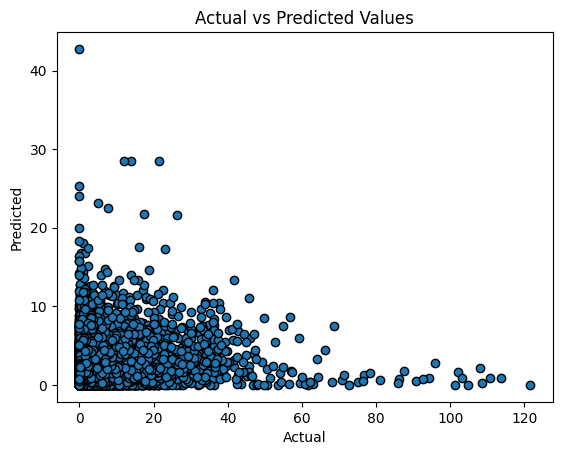

In [200]:
import matplotlib.pyplot as plt
# Plotting the actual vs predicted values
# plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred, edgecolors=(0, 0, 0))
# plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=4)
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.title('Actual vs Predicted Values')
plt.show()

tạo dataframe để thực hiện visualize

In [201]:
df_for_spatial_distribution = pd.DataFrame({
    'y_pred': y_pred,
    'col': data_test['Column Position'],
    'row': data_test['Row Position']
})
df_for_spatial_distribution

,y_pred,col,row
0,1.904419,109,16
1,0.000000,69,83
2,0.000000,18,82
3,0.000000,173,7
4,0.238996,235,77
...,...,...,...
39995,1.473952,103,20
39996,2.758788,135,20
39997,2.336991,129,21
39998,4.274359,121,67


Nếu như gán các giá trị dự đoán lớn hơn 1 về 1 để visualize

In [202]:
df_for_spatial_distribution['y_pred'] = df_for_spatial_distribution['y_pred'].clip(upper=1)
df_for_spatial_distribution

,y_pred,col,row
0,1.000000,109,16
1,0.000000,69,83
2,0.000000,18,82
3,0.000000,173,7
4,0.238996,235,77
...,...,...,...
39995,1.000000,103,20
39996,1.000000,135,20
39997,1.000000,129,21
39998,1.000000,121,67


Nếu như chuẩn hóa tập dữ liệu đầu ra về khoảng 0,1 để visualize

In [148]:
from sklearn.preprocessing import MinMaxScaler
values_2d = np.array(df_for_spatial_distribution['y_pred']).reshape(-1, 1)

# Initialize the MinMaxScaler
scaler = MinMaxScaler()

# Fit and transform the data
normalized_values = scaler.fit_transform(values_2d)

# Convert the normalized values back to a 1D array
df_for_spatial_distribution['y_pred'] = normalized_values.flatten()
df_for_spatial_distribution

,y_pred,col,row
0,0.044534,109,16
1,0.000000,69,83
2,0.000000,18,82
3,0.000000,173,7
4,0.005589,235,77
...,...,...,...
39995,0.034468,103,20
39996,0.064514,135,20
39997,0.054650,129,21
39998,0.099955,121,67


In [203]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.colors import LinearSegmentedColormap

Visualize đầu ra trên một ma trận

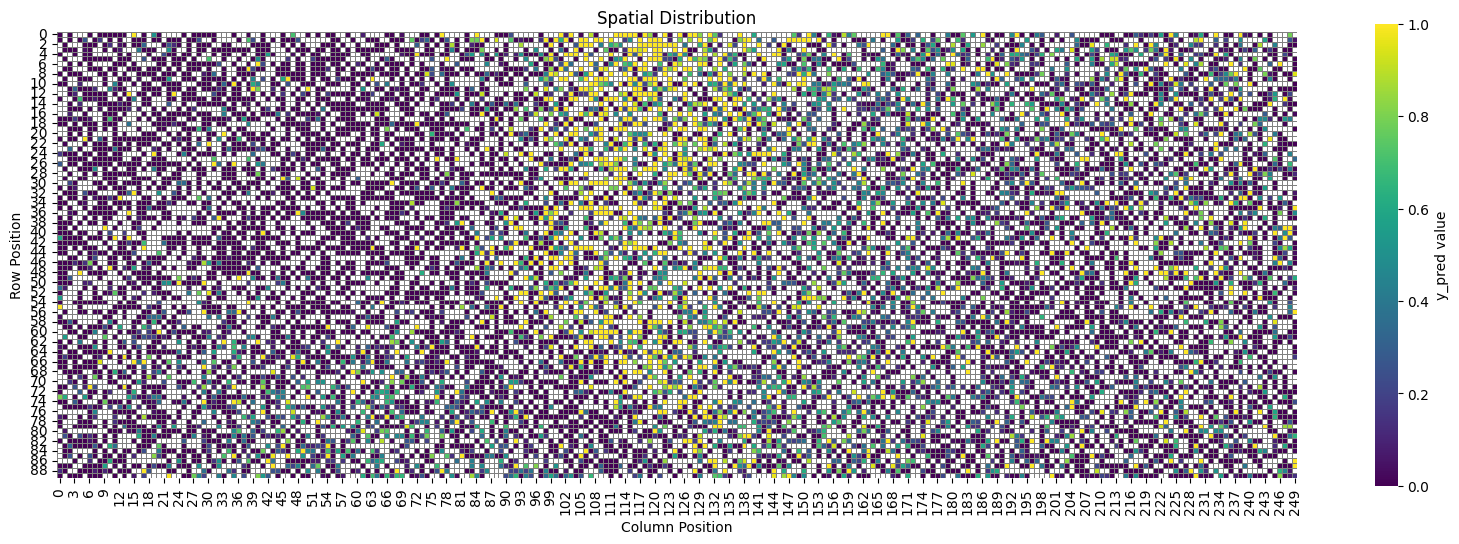

In [204]:
# Get the maximum row and column positions to define the matrix size
max_row = df_for_spatial_distribution['row'].max()
max_col = df_for_spatial_distribution['col'].max()

# Create an empty matrix filled with NaNs (will represent missing values)
matrix = np.full((max_row + 1, max_col + 1), np.nan)

# Fill the matrix with the y_pred values at the corresponding positions
for _, row in df_for_spatial_distribution.iterrows():
    matrix[row['row'].astype(int), row['col'].astype(int)] = row['y_pred']

# Create the heatmap
plt.figure(figsize=(20, 12))
cmap = sns.color_palette("viridis", as_cmap=True)

# Use seaborn to create a heatmap
sns.heatmap(matrix, cmap=cmap, cbar=True, linewidths=.5, linecolor='gray', square=True,
            mask=np.isnan(matrix), cbar_kws={'label': 'y_pred value', 'shrink': 0.5})

# Set titles and labels
plt.title('Spatial Distribution')
plt.xlabel('Column Position')
plt.ylabel('Row Position')

# Show the plot
plt.show()